Lösung Aufgabe 2

 In Ihrer Fabrik werden auf fünf verschiedenen Maschinen Schrauben produziert. Die Datei DatAn_PKA25_2.csv
 enthält die gemessenen Längen aller produzierten Schrauben, wobei die Spalte der Nummer der produzierenden Maschine entspricht.
 Untersuchen Sie die Messwerte und beantworten Sie insbesondere die folgenden Fragen:

A. Vorverarbeitung 

In [2]:
import pandas as pd
import numpy as np

path = "DatAn_PKA25_2.csv"

# Datei ist whitespace-getrennt, keine Header-Zeile
df = pd.read_csv(path, sep=r"\s+", header=None, engine="python")
df.columns = [f"Maschine_{i}" for i in range(1, 6)]

print("Shape:", df.shape)
print(df.head())
print(df.tail())


Shape: (25000, 5)
   Maschine_1  Maschine_2  Maschine_3  Maschine_4  Maschine_5
0     48.9392     49.4742     48.4472     48.5586     48.8089
1     49.1081     49.0365     48.9744     48.9943     48.6306
2     48.9219     49.0718     48.7498     49.2695     49.8966
3     49.4421     48.7563     49.2433     49.2323     49.0417
4     49.2517     49.2255     48.9356     49.2263     49.1596
         Maschine_1    Maschine_2    Maschine_3    Maschine_4    Maschine_5
24995  1.135841e+16  1.135977e+16  1.136113e+16  1.136250e+16  1.136386e+16
24996  1.136523e+16  1.136659e+16  1.136796e+16  1.136932e+16  1.137069e+16
24997  1.137205e+16  1.137342e+16  1.137479e+16  1.137615e+16  1.137752e+16
24998  1.137888e+16  1.138025e+16  1.138162e+16  1.138298e+16  1.138435e+16
24999  1.138571e+16  1.138708e+16  1.138845e+16  1.138981e+16  1.139118e+16


Ergebnis: 
Shape: (25000, 5) → 25.000 Schrauben je Maschine.
Die ersten Zeilen liegen um ~49 mm.
Die letzten Zeilen sind riesig (z.B. ~1.1e16).

Das ist ein Hinweis auf einen systematischen Fehler / Datenverarbeitungsfehler (z.B. „vertauschte Datensätze“, falsche Skalierung etc.).

Es gibt einen harten Bruch in der Größenordnung (ab Zeile 20000)

Wir suchen die erste Zeile, in der Werte „viel zu groß“ sind. Hier ist es so eindeutig, dass man sehr konservativ sein kann (z.B. > 1000).

In [3]:
mask_bad = (df.abs() > 1000).any(axis=1)   # irgendeine Maschine hat >1000
first_bad = mask_bad.idxmax() if mask_bad.any() else None
n_bad = int(mask_bad.sum())

print("Erste auffällige Zeile (0-basiert):", first_bad)
print("Anzahl auffälliger Zeilen:", n_bad)
print(df.iloc[first_bad-3:first_bad+3])



Erste auffällige Zeile (0-basiert): 20000
Anzahl auffälliger Zeilen: 5000
         Maschine_1    Maschine_2    Maschine_3    Maschine_4    Maschine_5
19997  5.300310e+01  5.942250e+01  7.355440e+01  5.417940e+01  5.007760e+01
19998  4.990170e+01  7.394000e+01  4.274110e+01  6.937470e+01  9.115530e+01
19999  7.028350e+01  3.362650e+01  4.238140e+01  6.802070e+01  4.654690e+01
20000  2.028753e+03  1.016093e+04  2.881952e+04  6.237853e+04  1.152120e+05
20001  1.916938e+05  2.961981e+05  4.330988e+05  6.067699e+05  8.215854e+05
20002  1.081919e+06  1.392146e+06  1.756639e+06  2.179772e+06  2.665919e+06


erste auffällige Zeile: 20000
auffällige Zeilen: 5000 (Zeilen 20000–24999)

Direkt um den Bruch sieht man:
Zeile 19999: noch Werte im „normalen“ Bereich (z.B. 30–90…)
Zeile 20000: plötzlich 2028, 10160, 28819, …

Das ist nicht „ein paar Ausreißer“, sondern ein kompletter Datenblock mit anderer Bedeutung/Skalierung.
Wenn man alles „roh“ auswertet, wird z.B. der Mittelwert komplett verfälscht, weil der gigantische Block dominiert:

In [4]:
print("Rohdaten describe():")
print(df.describe().T[["count","mean","std","min","50%","max"]])


Rohdaten describe():
              count          mean           std      min       50%  \
Maschine_1  25000.0  5.694316e+14  1.838963e+15  10.0440  49.64535   
Maschine_2  25000.0  5.695227e+14  1.839217e+15  10.8545  49.54440   
Maschine_3  25000.0  5.696139e+14  1.839471e+15  10.7941  49.57345   
Maschine_4  25000.0  5.697050e+14  1.839725e+15  11.3947  49.59095   
Maschine_5  25000.0  5.697961e+14  1.839979e+15  10.9472  49.56810   

                     max  
Maschine_1  1.138571e+16  
Maschine_2  1.138708e+16  
Maschine_3  1.138845e+16  
Maschine_4  1.138981e+16  
Maschine_5  1.139118e+16  


Roh-Mittelwerte liegen bei ca. 5.7e14 (absurd für Längenmessungen),
Median bleibt ~49 (weil Median robust ist).

Genau diese Sensitivität des Mittelwerts gegenüber Ausreißern wird im Skript thematisiert: der Median ist resistenter gegenüber Ausreißern. 

Typische Fragestellung: „Produziert meine Maschine noch Schrauben von 50mm Länge…?“ 
→ Das bestätigt den Größenordnungsrahmen: Werte wie 10^3 bis 10^16 sind kein plausibler Messbereich für diese Aufgabe.

In [5]:
df_block_ok = df.loc[~mask_bad].copy()   # 20000 Zeilen
df_block_bad = df.loc[mask_bad].copy()  # 5000 Zeilen

print(df_block_ok.shape, df_block_bad.shape)
print(df_block_ok.describe().T[["count","mean","std","min","50%","max"]])


(20000, 5) (5000, 5)
              count       mean        std      min       50%       max
Maschine_1  20000.0  50.556764  13.993887  10.0440  49.01510  181.2050
Maschine_2  20000.0  50.286956  13.717796  10.8545  48.99035  211.1635
Maschine_3  20000.0  50.370306  13.925683  10.7941  48.99080  194.5988
Maschine_4  20000.0  50.378425  13.849367  11.3947  49.00760  205.5622
Maschine_5  20000.0  50.282972  13.676546  10.9472  49.00285  184.7216


Schritt 1: korrupten Datenblock entfernen/isolieren

Das ist eine saubere Umsetzung dessen, was das Skript als systematische Fehler durch Verarbeitung/Vertauschung beschreibt.

df_block_ok: (20000, 5)

Mittelwerte ~50.3–50.6, Median ~49.0, Min ~10–11, Max ~181–211

df_block_bad: (5000, 5)

Min ab ~2028 und hoch bis ~1.1e16 (klar anderer Datensatz/Skala)

Entscheidung: Für die Schraubenlängen-Analyse verwenden wir nur df_block_ok. Den bad-block kann man als „defekte/fehlzugeordnete Messungen“ dokumentieren.

Schritt 2: Ausreißer im plausiblen Block behandeln

Ausreißer erkennt man u.a. daran, dass Messwerte außerhalb eines zulässigen Wertebereichs liegen (physikalisch / Messbereich). 

Behandlungsmöglichkeiten: markieren, korrigieren, als NaN ersetzen, entfernen. 

Für Boxplots: Ausreißer sind Punkte außerhalb von [Q1−1.5·IQR, Q3+1.5·IQR]. 

Da wir (noch) keine Toleranzgrenzen aus der Aufgabenstellung bekommen haben, ist die Boxplot-Regel eine gut begründbare, datengetriebene Standardmethode.

In [6]:
def boxplot_outlier_info(s):
    s = s.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    out = (s < lower) | (s > upper)
    return pd.Series({
        "Q1": q1, "Q3": q3, "IQR": iqr,
        "Lower": lower, "Upper": upper,
        "Outlier_n": int(out.sum()),
        "Outlier_frac": float(out.mean())
    })

out_table = df_block_ok.apply(boxplot_outlier_info)
print(out_table.T)


                   Q1         Q3        IQR      Lower      Upper  Outlier_n  \
Maschine_1  43.905300  54.983525  11.078225  27.287962  71.600863     1835.0   
Maschine_2  43.622075  54.484525  10.862450  27.328400  70.778200     1895.0   
Maschine_3  43.775075  54.564550  10.789475  27.590863  70.748762     1917.0   
Maschine_4  43.862550  54.618400  10.755850  27.728775  70.752175     1971.0   
Maschine_5  43.681900  54.602850  10.920950  27.300475  70.984275     1887.0   

            Outlier_frac  
Maschine_1       0.09175  
Maschine_2       0.09475  
Maschine_3       0.09585  
Maschine_4       0.09855  
Maschine_5       0.09435  


Die Boxplot-Grenzen liegen je Maschine ungefähr bei ~27 mm bis ~71 mm.
Ausreißeranteil je Maschine ca. 9.2% bis 9.9%.

Interpretation: Es gibt viele Werte weit weg vom zentralen Bereich um ~49 mm.
Ob das „Ausschuss“, „falsche Messung“ oder „andere Schraubenvariante“ ist, entscheidet die Aufgabenstellung. Deshalb ist es sauber, Ausreißer zunächst zu markieren (nicht einfach still zu löschen). Das entspricht Option 1/3 aus dem Skript (markieren oder als NaN ersetzen).

In [7]:
df_clean = df_block_ok.copy()

bounds = {}
for col in df_block_ok.columns:
    s = df_block_ok[col]
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    bounds[col] = (lower, upper)
    df_clean.loc[(s < lower) | (s > upper), col] = np.nan

print("NaNs nach Ausreißer-Markierung:")
print(df_clean.isna().sum())


NaNs nach Ausreißer-Markierung:
Maschine_1    1835
Maschine_2    1895
Maschine_3    1917
Maschine_4    1971
Maschine_5    1887
dtype: int64


1. Geben Sie zunächst Mittelwert, Standardabweichung, Skewness und Kurtosis der Messdaten (nach
 den jeweiligen Maschinen getrennt!) an.

In [8]:
means = df_block_ok.mean()
means_df = means.rename("Mittelwert").to_frame()
means_df


,Mittelwert
Maschine_1,50.556764
Maschine_2,50.286956
Maschine_3,50.370306
Maschine_4,50.378425
Maschine_5,50.282972


In [9]:
stds = df_block_ok.std(ddof=1)  # Stichproben-Standardabweichung (pandas default)
stds_df = stds.rename("Standardabweichung").to_frame()
stds_df

,Standardabweichung
Maschine_1,13.993887
Maschine_2,13.717796
Maschine_3,13.925683
Maschine_4,13.849367
Maschine_5,13.676546


In [10]:
skew = df_block_ok.skew()
skew_df = skew.rename("Skewness").to_frame()
skew_df


,Skewness
Maschine_1,1.791042
Maschine_2,1.610518
Maschine_3,1.807396
Maschine_4,1.718748
Maschine_5,1.631759


In [11]:
kurt = df_block_ok.kurt()
kurt_df = kurt.rename("Kurtosis").to_frame()
kurt_df


,Kurtosis
Maschine_1,8.443975
Maschine_2,7.037238
Maschine_3,8.705320
Maschine_4,8.061227
Maschine_5,7.493070


2. Untersuchen Sie die fünf Verteilungsfunktionen auf Symmetrie. Bei welchen der Verteilungsfunk
tionen liegt eine Normalverteilung vor? Beschreiben Sie die Abweichung der anderen Verteilungs
funktionen von der Normalverteilung.

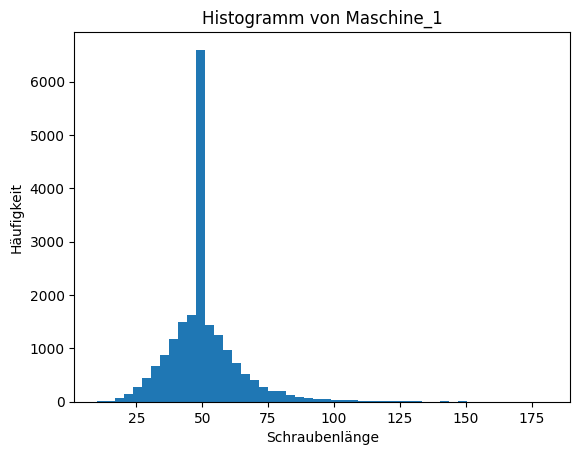

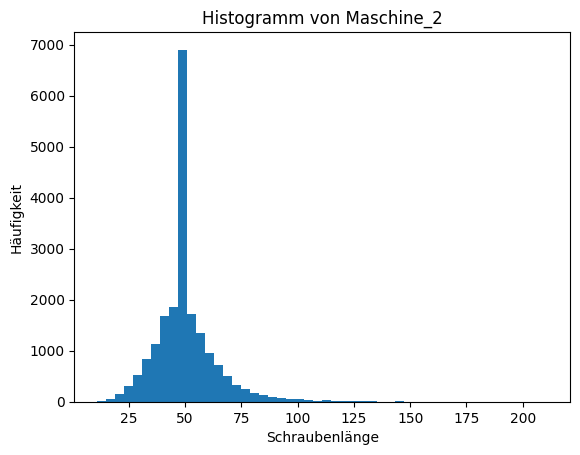

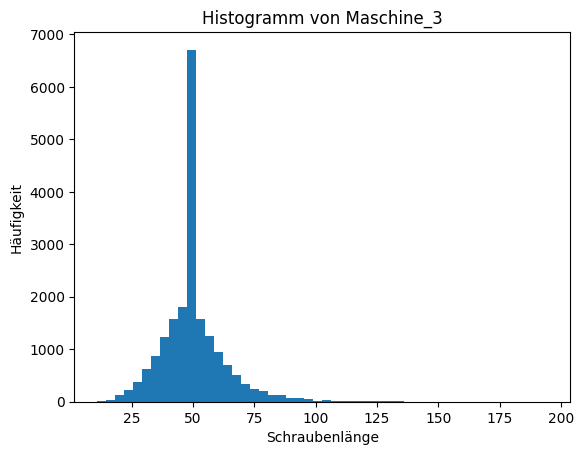

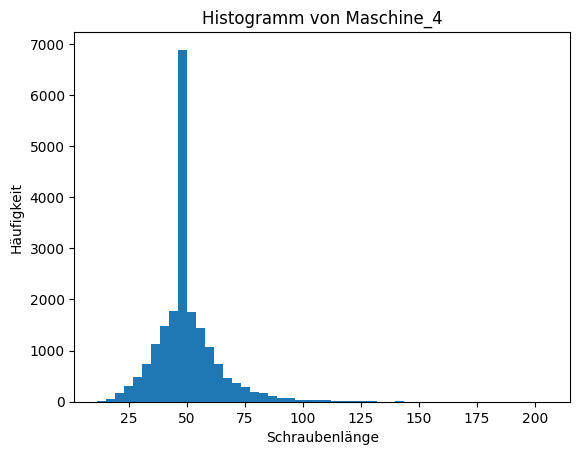

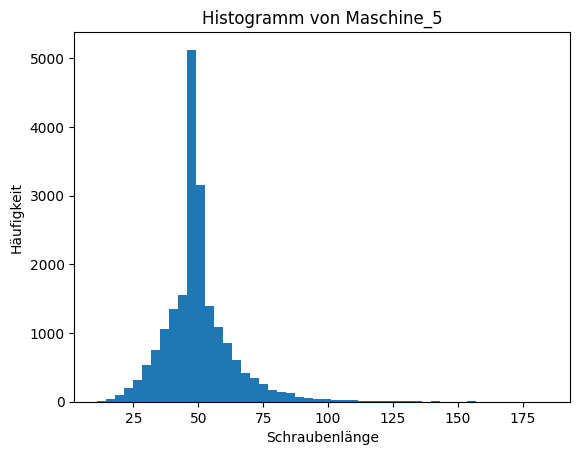

In [21]:
import matplotlib.pyplot as plt

for col in df_block_ok.columns:
    plt.figure()
    plt.hist(df_block_ok[col], bins=50)
    plt.title(f"Histogramm von {col}")
    plt.xlabel("Schraubenlänge")
    plt.ylabel("Häufigkeit")
    plt.show()


 3. Untersuchen Sie, ob sich die von den verschiedenen Maschinen erzeugten Verteilungsfunktionen
 in ihrer Formvoneinander unterscheiden. Haben zwei der Verteilungsfunktionen die gleiche Form?